\newpage

In [10]:
!pip install numpy pandas matplotlib seaborn scikit-learn patsy statsmodels

In [315]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from patsy import dmatrices, dmatrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import pearsonr
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

In [264]:
CKD = pd.read_csv('/Users/xueqizhang/Desktop/Chronic_Kidney_Disease.csv')

1.

The primary objective is to predict whether an individual has chronic kidney disease (CKD) based on their clinical and demographic features.

2.

In [265]:
CKD.dtypes

age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv                object
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

In [266]:
# Since 'pcv', 'wc' and 'rc' are object, we need to convert them to numerical.

CKD['pcv'] = pd.to_numeric(CKD['pcv'], errors='coerce')
CKD['wc'] = pd.to_numeric(CKD['wc'], errors='coerce')
CKD['rc'] = pd.to_numeric(CKD['rc'], errors='coerce')

In [267]:
# Extracting categorical and numerical columns

categorical = [col for col in CKD.columns if CKD[col].dtype == 'object']
numerical = [col for col in CKD.columns if CKD[col].dtype != 'object']

In [269]:
# Check unique values in categorical columns
unique_values_dict = {}

for col in categorical:
    unique_values_dict[col] = CKD[col].unique()

for col, values in unique_values_dict.items():
    print(f"Unique values in '{col}': {values}")


Unique values in 'rbc': [nan 'normal' 'abnormal']
Unique values in 'pc': ['normal' 'abnormal' nan]
Unique values in 'pcc': ['notpresent' 'present' nan]
Unique values in 'ba': ['notpresent' 'present' nan]
Unique values in 'htn': ['yes' 'no' nan]
Unique values in 'dm': ['yes' 'no' ' yes' '\tno' '\tyes' nan]
Unique values in 'cad': ['no' 'yes' '\tno' nan]
Unique values in 'appet': ['good' 'poor' nan]
Unique values in 'pe': ['no' 'yes' nan]
Unique values in 'ane': ['no' 'yes' nan]
Unique values in 'classification': ['ckd' 'ckd\t' 'notckd']


In [270]:
# replace incorrect values

CKD['dm'].replace(to_replace = {'\tno':'no','\tyes':'yes',' yes':'yes'},inplace=True)

CKD['cad'] = CKD['cad'].replace(to_replace = '\tno', value='no')

CKD['classification'] = CKD['classification'].replace(to_replace = {'ckd\t': 'ckd', 'notckd': 'not ckd'})

In [272]:
unique_values_dict = {}

for col in categorical:
    unique_values_dict[col] = CKD[col].unique()

for col, values in unique_values_dict.items():
    print(f"Unique values in '{col}': {values}")

Unique values in 'rbc': [nan 'normal' 'abnormal']
Unique values in 'pc': ['normal' 'abnormal' nan]
Unique values in 'pcc': ['notpresent' 'present' nan]
Unique values in 'ba': ['notpresent' 'present' nan]
Unique values in 'htn': ['yes' 'no' nan]
Unique values in 'dm': ['yes' 'no' nan]
Unique values in 'cad': ['no' 'yes' nan]
Unique values in 'appet': ['good' 'poor' nan]
Unique values in 'pe': ['no' 'yes' nan]
Unique values in 'ane': ['no' 'yes' nan]
Unique values in 'classification': ['ckd' 'not ckd']


Since there are still missing values in the dataset, I will apply label encoding for categorical variables after handling missing values which is on question 5. 

And for numerical variables, I apply standard scaling to them.

In [273]:
scaler = StandardScaler()

CKD_scaled = CKD.copy()

CKD_scaled[numerical] = scaler.fit_transform(CKD_scaled[numerical])

3.

In [274]:
CKD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             329 non-null    float64
 16  wc              294 non-null    float64
 17  rc              269 non-null    flo

In [275]:
CKD.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


/var/folders/8q/z7rxs5cn6n16v0mx8gjy7g_m0000gn/T/ipykernel_80469/2399412739.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(CKD[column], kde=True, color='orange')
/var/folders/8q/z7rxs5cn6n16v0mx8gjy7g_m0000gn/T/ipykernel_80469/2399412739.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(C

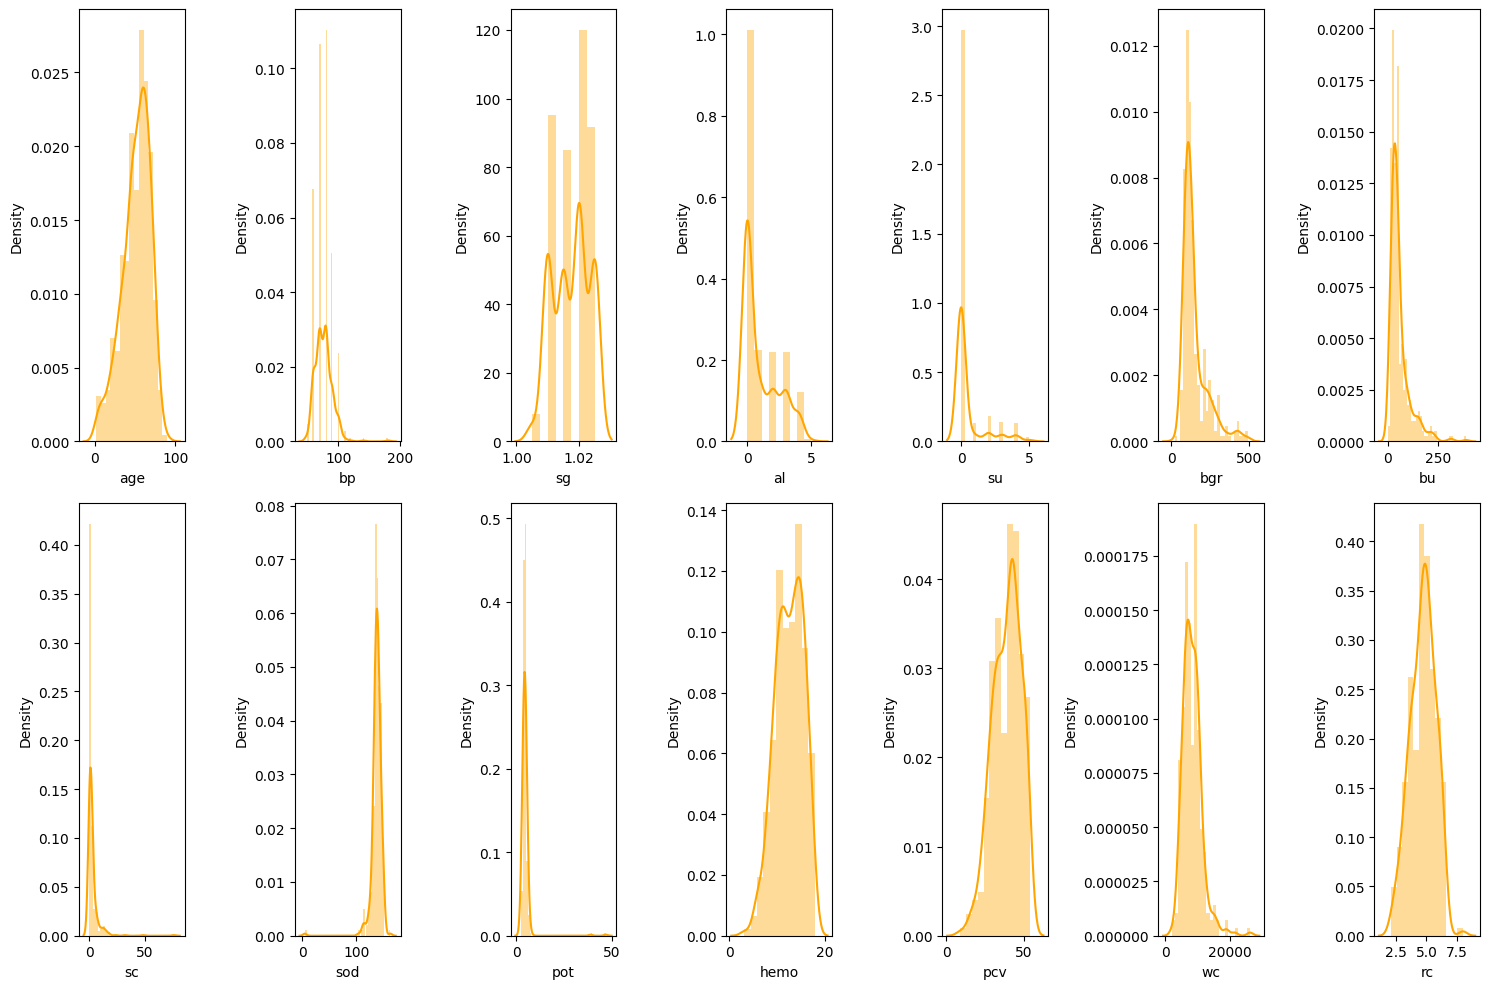

In [276]:
plt.figure(figsize = (15, 10))
plotnumber = 1

for column in numerical:
    if plotnumber <= 14:
        ax = plt.subplot(2, 7, plotnumber)
        sns.distplot(CKD[column], kde=True, color='orange')
        plt.xlabel(column)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

/var/folders/8q/z7rxs5cn6n16v0mx8gjy7g_m0000gn/T/ipykernel_80469/2211065572.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=variable_of_interest, data=CKD, palette='deep')  # Using a vibrant palette


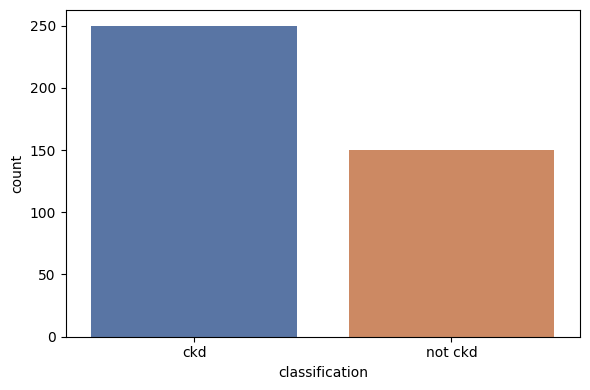

In [277]:
variable_of_interest = 'classification'

plt.figure(figsize=(6, 4)) 
sns.countplot(x=variable_of_interest, data=CKD, palette='deep')  # Using a vibrant palette
plt.xlabel(variable_of_interest)
plt.tight_layout()
plt.show()

The dataset has 400 observations and 25 variables. 11 of them are numerical variables and 14 of them are nominal variables. Several columns have missing values, notably rbc, wc, and rc, which have significant numbers of missing entries. Proper handling will be necessary for accurate analysis. 

From the distribution plots of the numerical variables, several variables show significant skewness or potential outliers. For example, su, bgr, and sc have long tails to the right, indicating positive skewness. This suggests that there are patients with significantly higher readings for these variables, which could be of clinical significance. 

There is a noticeable difference in the number of cases for the two classes. The number of CKD cases(250) is higher than the number of non-CKD cases(150). 









4.

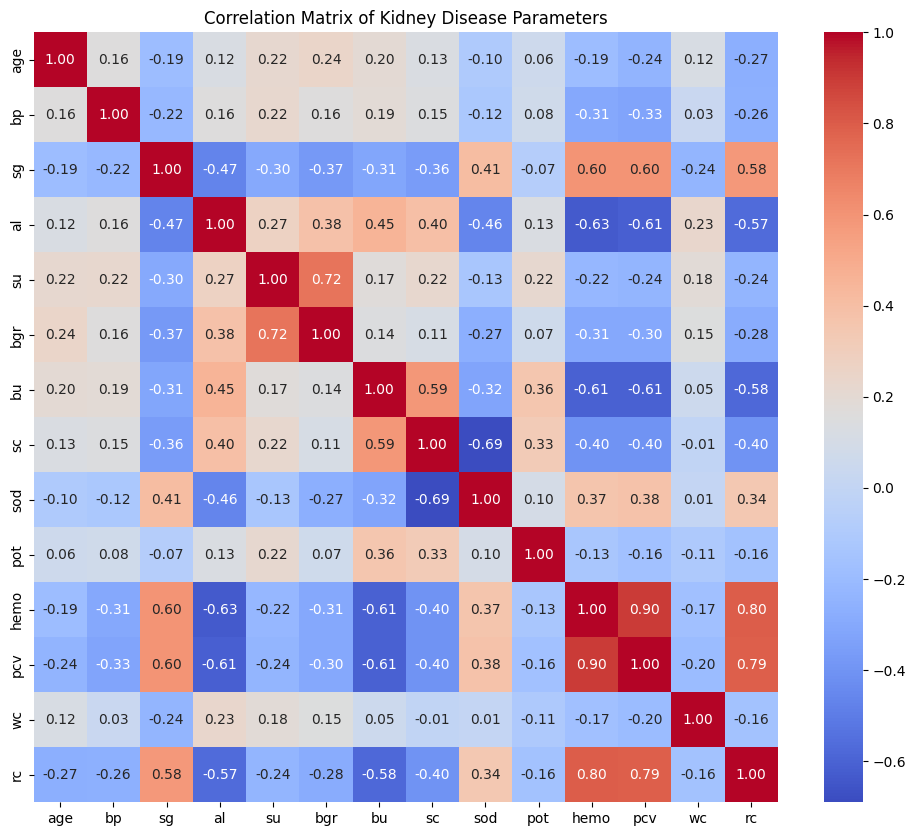

In [278]:
correlation_matrix = CKD[numerical].corr()

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Kidney Disease Parameters')
plt.show()


There is a strong positive correlation between 'bgr' (blood glucose random) and 'su' (sugar), with a correlation coefficient of 0.72. This suggests that as the blood glucose level increases, the sugar level tends to increase as well. For feature selection or extraction, this could imply that including both of these variables might be redundant, as they provide similar information. 


The correlation between 'sc' (serum creatinine) and 'sod' (sodium) is quite strongly negative, with a correlation coefficient of -0.69. This implies that as serum creatinine levels increase, which often indicates reduced kidney function, sodium levels tend to decrease. It should be cautious about including both 'sc' and 'sod' because of potential multicollinearity issues, which can inflate the variance of the coefficient estimates and make the model less reliable.

Some variables show very weak or no correlation with others, such as 'pot' with 'sod', and 'age' with 'pot', with correlation coefficients of 0.10 and 0.06, respectively. These low correlations suggest that these variables provide unique information that is not shared with others. Thus, they might all be considered for inclusion in a predictive model because they contribute different aspects of the disease.



5.

In [279]:
missing_values = CKD.isnull().sum()
missing_values

age                 9
bp                 12
sg                 47
al                 46
su                 49
rbc               152
pc                 65
pcc                 4
ba                  4
bgr                44
bu                 19
sc                 17
sod                87
pot                88
hemo               52
pcv                71
wc                106
rc                131
htn                 2
dm                  2
cad                 2
appet               1
pe                  1
ane                 1
classification      0
dtype: int64

In [280]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in categorical:
    CKD_scaled[col] = le.fit_transform(CKD_scaled[col])

In [281]:
# Filling missing values for numerical columns with the mean
CKD_scaled[numerical] = CKD_scaled[numerical].apply(lambda x: x.fillna(x.mean()))

# Filling missing values for categorical columns with the mode
for column in categorical:
    mode_value = CKD_scaled[column].mode()[0]
    CKD_scaled[column].fillna(mode_value, inplace=True)

# Check if all missing values are filled
CKD_scaled.isnull().sum()

age               0
bp                0
sg                0
al                0
su                0
rbc               0
pc                0
pcc               0
ba                0
bgr               0
bu                0
sc                0
sod               0
pot               0
hemo              0
pcv               0
wc                0
rc                0
htn               0
dm                0
cad               0
appet             0
pe                0
ane               0
classification    0
dtype: int64

6.

In [282]:
def calculate_outliers(CKD, column):
    Q1 = CKD[column].quantile(0.25)
    Q3 = CKD[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = CKD[(CKD[column] < lower_bound) | (CKD[column] > upper_bound)]
    return outliers

outliers_dict = {}

for column in numerical:
    outliers_dict[column] = calculate_outliers(CKD, column)

outlier_counts = {column: len(outliers_dict[column]) for column in numerical}
outlier_counts

{'age': 10,
 'bp': 36,
 'sg': 0,
 'al': 0,
 'su': 61,
 'bgr': 34,
 'bu': 38,
 'sc': 51,
 'sod': 16,
 'pot': 4,
 'hemo': 1,
 'pcv': 1,
 'wc': 10,
 'rc': 1}

I choose not to address these outliers and below is my reasons:

In medical datasets like the CKD dataset, outliers may represent clinically significant cases that are critical to understanding the full scope of the disease. Removing them could eliminate important information that could lead to a better understanding of CKD. 

Some outliers could be indicative of misdiagnosis or more severe stages of the disease. In the context of CKD, extreme values in certain variables could be symptomatic of advanced disease and therefore crucial for prediction and diagnosis. 

For this dataset and its context, there may not be a clear, justifiable reason to remove or replace outliers, and doing so without a good reason could introduce bias into the analysis.

7.

In [283]:
CKD_dropclass = CKD_scaled.drop(columns=['classification'])

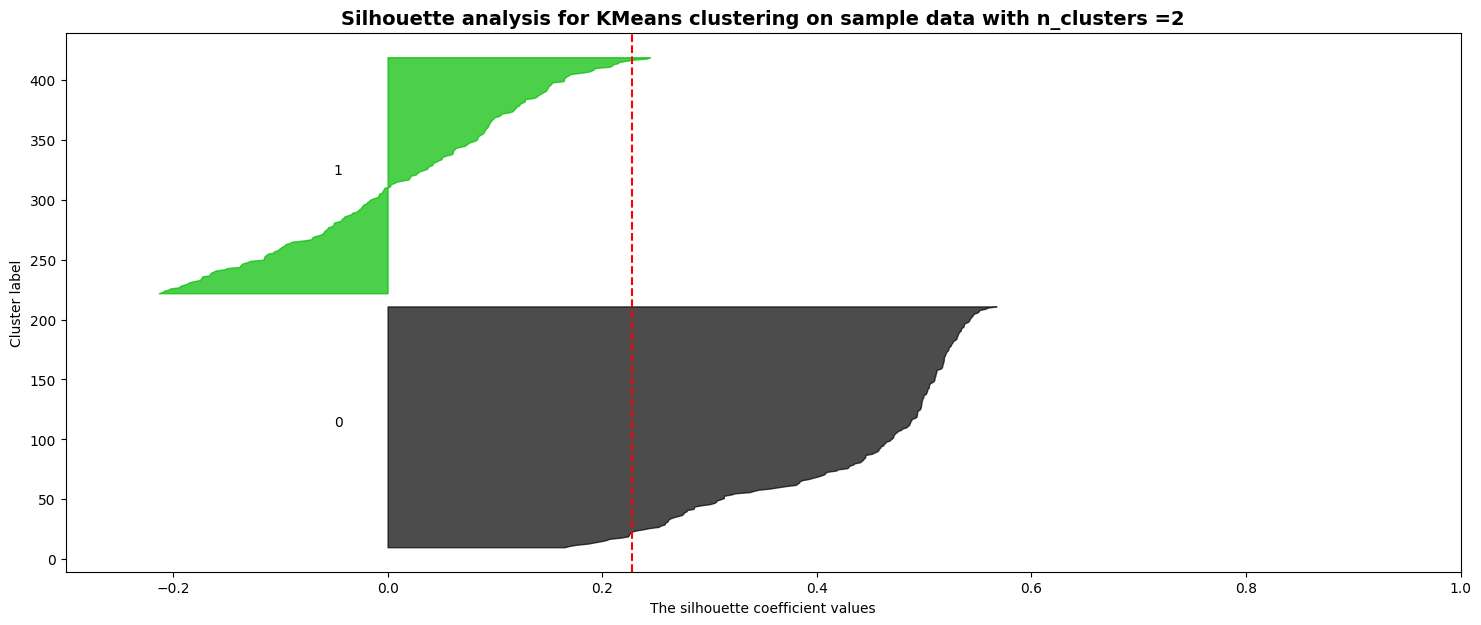

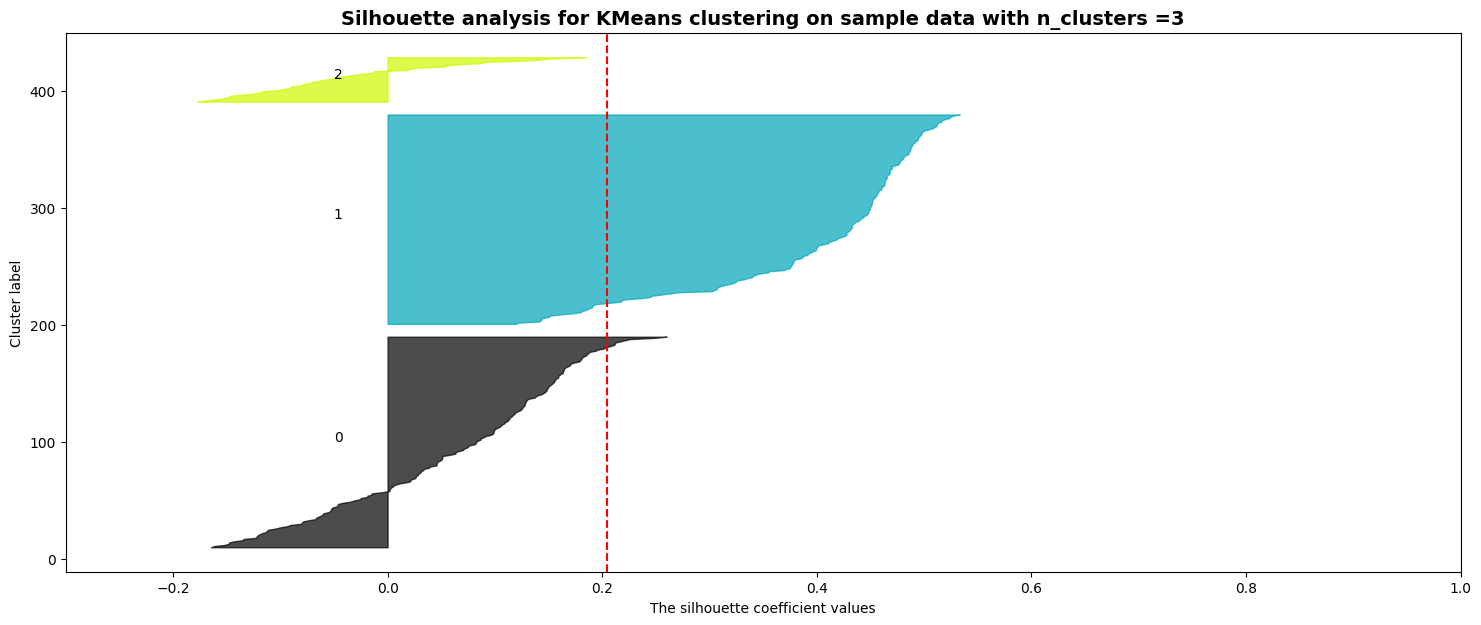

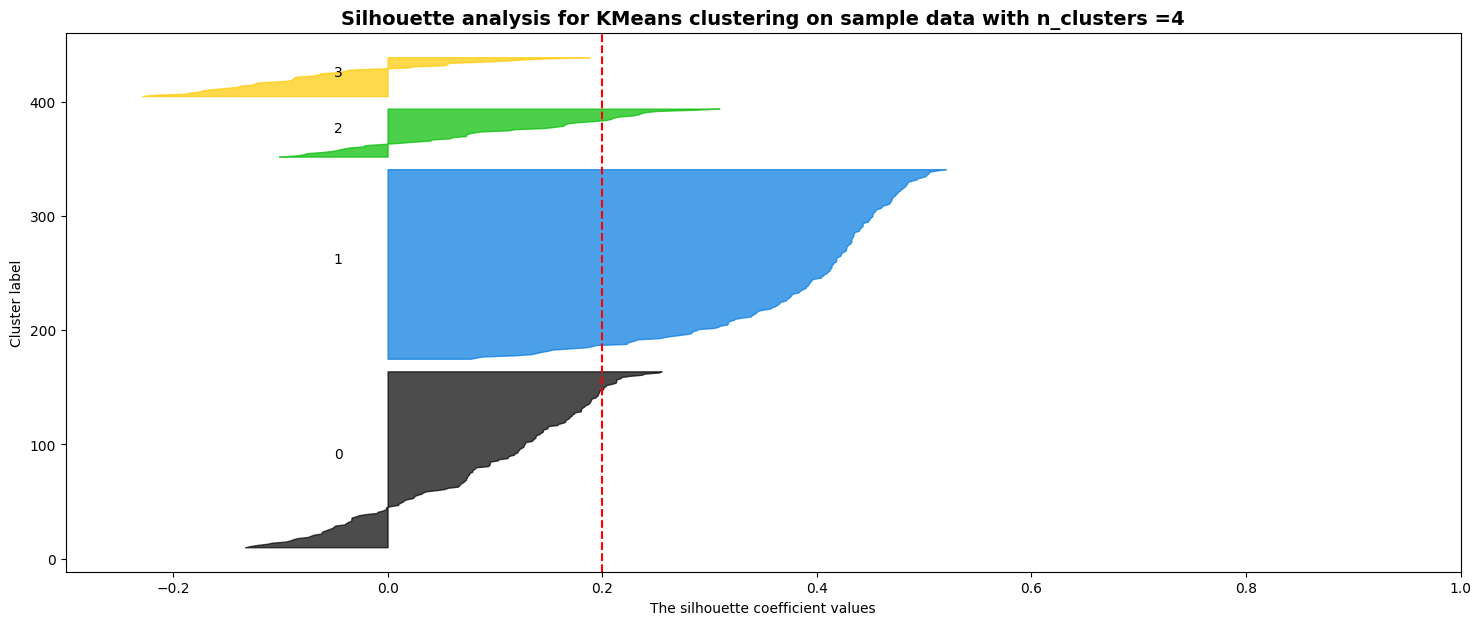

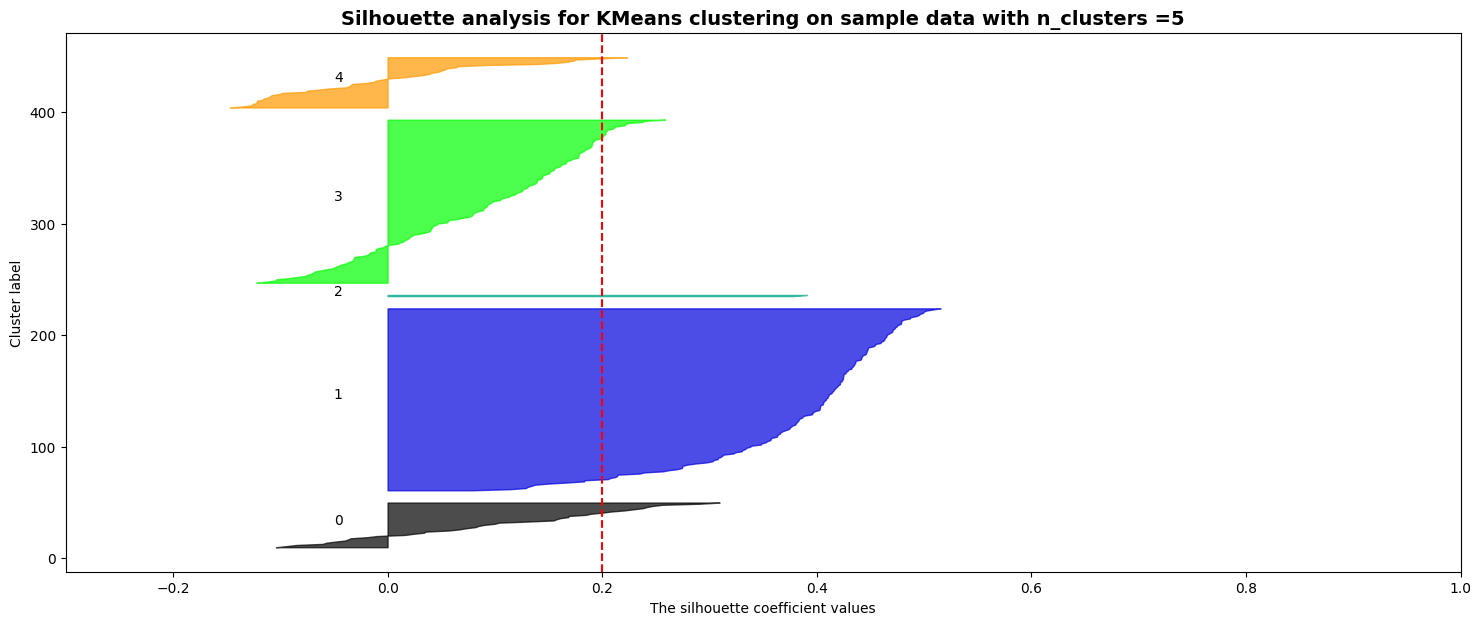

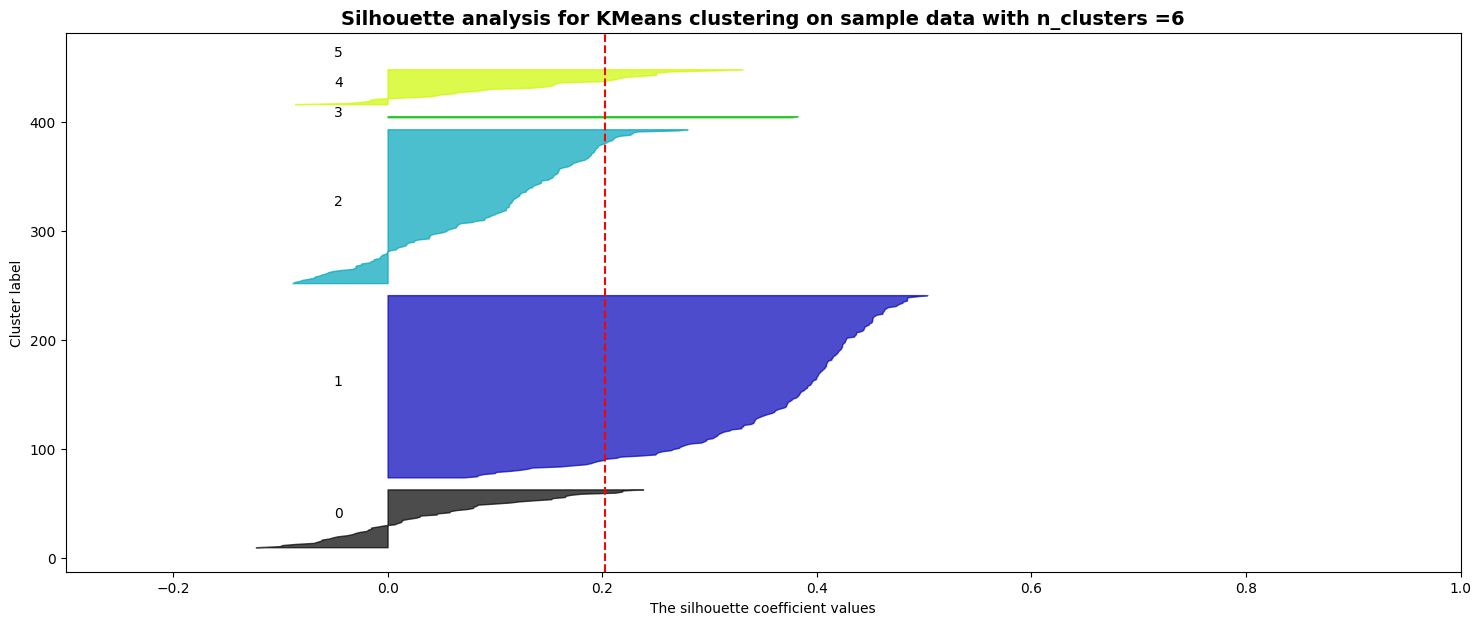

In [225]:
range_n_clusters = [2, 3, 4,5,6]
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters = n_clusters, n_init = 20, random_state=0) 
    cluster_labels_km = km.fit_predict(CKD_dropclass)
    # average silhouette score
    silhouette_avg_km = silhouette_score(CKD_dropclass, cluster_labels_km)
    # compute the silhouette scores for each sample 
    sample_silhouette_values = silhouette_samples(CKD_dropclass, cluster_labels_km)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.3, 1])# change this based on the silhouette range
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels_km==i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters) 
        ax1.fill_betweenx(
            y=np.arange(y_lower, y_upper),
              x1=0, 
              x2=ith_cluster_silhouette_values, 
              facecolor=color, 
              edgecolor=color,
              alpha=0.7, 
        )
        # label the silhouette plots with their cluster numbers at the middle 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Compute the new y_lower for next cluster silhouette scores 
        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for various cluster") 
    ax1.set_xlabel("The silhouette coefficient values") 
    ax1.set_ylabel("Cluster label")
    # vertical line for average silhouette score of all the values 
    ax1.axvline(x=silhouette_avg_km, color="red", linestyle="--") 
    plt.title(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters =%d"
        % n_clusters, fontsize=14, fontweight="bold",
    ) 
plt.show()

In [222]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(CKD_dropclass)
labels = kmeans.labels_

/Users/xueqizhang/Desktop/STATS 3DA/.venv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


8.

In [284]:
ind = [col for col in CKD_scaled.columns if col != 'classification']
dep = 'classification'

X = CKD_scaled[ind]
y = CKD_scaled[dep]

In [285]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 1)

9.

K-Nearest Neighbors (KNN): 
It makes predictions based on the nearest training examples in the feature space, which is ideal for medical datasets where similar cases often have similar outcomes. It doesn't assume anything about the underlying data distribution, which is beneficial when the data is highly irregular, as is common in medical datasets. Additionally, given that this dataset isn't extremely large (400 entries), KNN can perform well without the need for extensive training or optimization.

Random Forest Classifier: 
Random forests can handle a mix of numerical and categorical data effectively, making them ideal for a dataset like this which includes both types. Also, random forests can model non-linear relationships between features without requiring transformations, which is advantageous given the complex nature of medical data. Additionally, it also provides insights into the importance of different features in prediction, which can be crucial for medical diagnostics and understanding which factors contribute most to CKD. 

10.

AUC-ROC:
In medical diagnostics including CKD prediction, we often need a balance between sensitivity (identifying all positive cases) and specificity (not falsely labeling negative cases as positive). AUC-ROC is particularly useful because it provides a single measure of performance irrespective of a specific classification threshold, allowing for an assessment of the model’s ability to discriminate between the two classes across all possible thresholds. 

F1 Score: 
In the context of CKD, where it might be critical to correctly identify as many true cases of the disease as possible while minimizing the number of false positives (to avoid unnecessary treatments), the F1 score provides a more balanced measure of a model's accuracy than accuracy alone, especially in datasets where there may be an imbalance between the two classes.

11.

In [286]:
rf_model = RandomForestClassifier(random_state=0)

In [287]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [288]:
importances = rf_model.feature_importances_

In [289]:
features_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

In [290]:
sorted_features = features_importance.sort_values(by='Importance', ascending=False)

In [291]:
print(sorted_features)

   Feature  Importance
14    hemo    0.217507
15     pcv    0.146236
2       sg    0.118516
3       al    0.098447
11      sc    0.083964
17      rc    0.062702
5      rbc    0.045802
9      bgr    0.034378
19      dm    0.033274
10      bu    0.031332
18     htn    0.030266
12     sod    0.029121
4       su    0.014091
0      age    0.010946
1       bp    0.010192
13     pot    0.008855
16      wc    0.007011
21   appet    0.004201
6       pc    0.004132
22      pe    0.003723
23     ane    0.003013
20     cad    0.001600
8       ba    0.000616
7      pcc    0.000074


In [292]:
# Select top 10 features

top_features = sorted_features['Feature'].head(10)

In [293]:
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

In [294]:
# Re-train the Random Forest classifier with selected features

rf_selected = RandomForestClassifier(random_state=0)
rf_selected.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=0)

12.

In [313]:
knn_params = {
    'n_neighbors': [3, 5, 7, 10],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

rf_params = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30]
}

In [314]:
# Create GridSearchCV for KNN
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, knn_params, cv=5, scoring='roc_auc')
grid_knn.fit(X_train_selected, y_train)

# Create GridSearchCV for Random Forest
rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, rf_params, cv=5, scoring='roc_auc')
grid_rf.fit(X_train_selected, y_train)

/Users/xueqizhang/Desktop/STATS 3DA/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
80 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/xueqizhang/Desktop/STATS 3DA/.venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/xueqizhang/Desktop/STATS 3DA/.venv/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/xueqizhang/Desktop/STATS 3DA/.venv/lib/python3.8/site-packages/sklearn/base.py", line 638

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='roc_auc')

In [ ]:
# Create GridSearchCV for KNN
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, knn_params, cv=5, scoring='roc_auc')
grid_knn.fit(X_train, y_train)

# Create GridSearchCV for Random Forest
rf = RandomForestClassifier()
grid_rf = GridSearchCV(rf, rf_params, cv=5, scoring='roc_auc')
grid_rf.fit(X_train, y_train)

In [320]:
best_knn_model = grid_knn.best_estimator_
best_rf_model = grid_rf.best_estimator_

In [321]:
knn_predictions = best_knn_model.predict(X_test_selected)
rf_predictions = best_rf_model.predict(X_test_selected)

In [322]:
knn_roc_auc = roc_auc_score(y_test, knn_predictions)
knn_f1 = f1_score(y_test, knn_predictions)
rf_roc_auc = roc_auc_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)

In [323]:
print("KNN AUC-ROC:", knn_roc_auc)
print("KNN F1 Score:", knn_f1)
print("Random Forest AUC-ROC:", rf_roc_auc)
print("Random Forest F1 Score:", rf_f1)

KNN AUC-ROC: 0.9928571428571429
KNN F1 Score: 0.99009900990099
Random Forest AUC-ROC: 1.0
Random Forest F1 Score: 1.0


Findings: 

The Random Forest classifier achieved perfect scores with an AUC-ROC of 1.0 and an F1 Score of 1.0. This suggests that the model was able to perfectly distinguish between the positive and negative classes and achieved perfect precision and recall in the test set. Such a result could indicate that the model has captured the underlying patterns in the data very well. However, it might also raise concerns about overfitting, as perfect metrics are quite rare in practice. 

The KNN classifier also showed excellent performance with an AUC-ROC and F1 Score of 0.99, which are very close to perfect. These results indicate that KNN is also highly effective at classifying the CKD instances correctly. The performance of KNN heavily depends on the choice of the 'n_neighbors' parameter. The finding that the KNN performed well suggests that the hyperparameter tuning successfully identified a number of neighbors that works well for the dataset.

13.

In [ ]:
# Assuming we have the best_params from the GridSearch
best_params = {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 2}
rf_classifier = RandomForestClassifier(**best_params, random_state=0)

# Retrain on the entire dataset using the selected features
rf_classifier.fit(X[top_features], y)

# Get feature importances
importances = rf_classifier.feature_importances_

# Create a DataFrame to view the features and their importance scores
features_importance = pd.DataFrame({
    'Feature': top_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print(features_importance)

\newpage